In [9]:

import matplotlib.pyplot as plt
from spikingjelly.activation_based import neuron, functional, surrogate, layer
from spikingjelly.activation_based.encoding import PoissonEncoder
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm

from data import PermutedMNIST
from utils import EWC, ewc_train, normal_train, test
import spikingjelly as sj
from spikingjelly.activation_based import encoding

In [10]:
epochs = 50
lr = 5e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3


In [11]:
# class SNN(nn.Module):
#     def __init__(self, hidden_size=200):
#         super(SNN, self).__init__()
#         # 输入层到隐藏层的权重
#         self.fc1 = nn.Linear(28 * 28, hidden_size, bias=False)  # 无偏置项
#         # 隐藏层LIF神经元
#         self.lif1 = sj.activation_based.neuron.LIFNode(tau=10.0)
#         # 隐藏层到隐藏层的权重
#         self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)  # 无偏置项
#         # 另一个隐藏层LIF神经元
#         self.lif2 = sj.activation_based.neuron.LIFNode(tau=10.0)
#         # 另一个隐藏层到隐藏层的权重
#         self.fc3 = nn.Linear(hidden_size, hidden_size, bias=False)  # 无偏置项
#         # 最后一个隐藏层LIF神经元
#         self.lif3 = sj.activation_based.neuron.LIFNode(tau=10.0)
#         # 输出层权重
#         self.lif4 = sj.activation_based.neuron.LIFNode(tau=10.0)  # 无偏置项

#     def forward(self, input):
#         # 输入编码为尖峰信号
#         x = sj.activation_based.encoding.StatelessEncoder()(input)
#         # 第一个隐藏层
#         x = self.fc1(x)
#         x, _ = self.lif1(x)
#         # 第二个隐藏层
#         x = self.fc2(x)
#         x, _ = self.lif2(x)
#         # 第三个隐藏层
#         x = self.fc3(x)
#         x, _ = self.lif3(x)
#         # 输出层
#         x = self.lif4(x)
#         return x
# # 创建SNN模型实例

class SNN(nn.Module):
    def __init__(self, tau):
        super().__init__()
        self.encoder = encoding.PoissonEncoder()  # 将编码器作为模型的一部分
        self.layer = nn.Sequential(
            layer.Flatten(),
            layer.Linear(28 * 28, 10, bias=False),
            neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan()),
        )

    def forward(self, x: torch.Tensor):
        # 编码输入图像为尖峰信号
        x = self.encoder(x)
        # 通过SNN层进行前向传播
        return self.layer(x)
snn_model = SNN(tau=2.0)

In [12]:
# class MLP(nn.Module):
#     def __init__(self, hidden_size=400):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(28 * 28, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)
#         self.fc4 = nn.Linear(hidden_size, 10)

#     def forward(self, input):
#         x = F.relu(self.fc1(input))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x)) 
#         return x


In [13]:
# def get_permute_mnist():
#     train_loader = {}
#     test_loader = {}
#     idx = list(range(28 * 28))
#     for i in range(num_task):
#         train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(root= 'C:\\Users\\86185\\Desktop\\ewc.pytorch-master',train=True, permute_idx=idx),
#                                                       batch_size=batch_size,
#                                                       num_workers=4
#                                                       )
#         test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(root= 'C:\\Users\\86185\\Desktop\\ewc.pytorch-master',train=False, permute_idx=idx),
#                                                      batch_size=batch_size)
#         random.shuffle(idx)
#     return train_loader, test_loader


# train_loader, test_loader = get_permute_mnist()
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(root= 'C:\\Users\\86185\\Desktop\\ewc.pytorch-master',train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4
                                                      )
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(root= 'C:\\Users\\86185\\Desktop\\ewc.pytorch-master',train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()


In [14]:
# from spikingjelly.activation_based import neuron,ann2snn
# from spikingjelly import visualizing

# def standard_process(epochs, use_cuda=True, weight=True):
#     # model = MLP(hidden_size)
#     # model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
#     # model = model_converter(model)
#     model= snn_model
#     if torch.cuda.is_available() and use_cuda:
#         model.cuda()
#     optimizer = optim.SGD(params=model.parameters(), lr=lr)

#     loss, acc = {}, {}
#     for task in range(num_task):
#         loss[task] = []
#         acc[task] = []
#         for _ in tqdm(range(epochs)):
#             loss[task].append(normal_train(model, optimizer, train_loader[task]))
            
#             for sub_task in range(task + 1):
#                 acc[sub_task].append(test(model, test_loader[sub_task]))
#         if task == 0 and weight:
#             weight = model.state_dict()
#     return loss, acc, weight


# def ewc_process(epochs, importance, use_cuda=True, weight=None):
#     # model = MLP(hidden_size)
#     # model_converter = ann2snn.Converter(mode='max', dataloader=train_loader)
#     # model = model_converter(model)
#     model= snn_model
#     if torch.cuda.is_available() and use_cuda:
#         model.cuda()
#     optimizer = optim.SGD(params=model.parameters(), lr=lr)

#     loss, acc, ewc = {}, {}, {}
#     for task in range(num_task):
#         loss[task] = []
#         acc[task] = []

#         if task == 0:
#             if weight:
#                 model.load_state_dict(weight)
#             else:
#                 for _ in tqdm(range(epochs)):
#                     loss[task].append(normal_train(model, optimizer, train_loader[task]))
#                     acc[task].append(test(model, test_loader[task]))
#         else:
#             old_tasks = []
#             for sub_task in range(task):
#                 old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
#             old_tasks = random.sample(old_tasks, k=sample_size)
#             for _ in tqdm(range(epochs)):
#                 loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
#                 for sub_task in range(task + 1):
#                     acc[sub_task].append(test(model, test_loader[sub_task]))

#     return loss, acc
from spikingjelly.activation_based import neuron,ann2snn
from spikingjelly import visualizing

from tqdm import tqdm
import torch
import torch.optim as optim
import spikingjelly as sj

# 假设 normal_train 和 test 函数已经适配了 SNN，能够处理尖峰信号

def standard_process(epochs, use_cuda=True, weight=True):
    model = snn_model
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    #optimizer = optim.SGD(params=model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    encoder = PoissonEncoder()  # 确保导入正确的PoissonEncoder
    loss, acc = {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        for epoch in tqdm(range(epochs), desc=f'Task {task}'):
            epoch_loss = normal_train(model, optimizer, train_loader[task], encoder)
            loss[task].append(epoch_loss)
            epoch_acc = 0
            for sub_task in range(task + 1):
                sub_acc = test(model, test_loader[sub_task], encoder)
                acc[sub_task].append(sub_acc)
                epoch_acc += sub_acc
            epoch_acc /= (task + 1)
            print(f'Task {task}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight

def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = snn_model
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)
    encoder = PoissonEncoder()  # 确保导入正确的PoissonEncoder
    loss, acc, ewc = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for epoch in tqdm(range(epochs), desc=f'Task 0'):
                    epoch_loss = normal_train(model, optimizer, train_loader[task], encoder)
                    loss[task].append(epoch_loss)
                    epoch_acc = test(model, test_loader[task], encoder)
                    acc[task].append(epoch_acc)
                    print(f'Task 0, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks += train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for epoch in tqdm(range(epochs), desc=f'Task {task}'):
                epoch_loss = ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance, encoder)
                loss[task].append(epoch_loss)
                epoch_acc = 0
                for sub_task in range(task + 1):
                    sub_acc = test(model, test_loader[sub_task], encoder)
                    acc[sub_task].append(sub_acc)
                    epoch_acc += sub_acc
                epoch_acc /= (task + 1)
                print(f'Task {task}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return loss, acc, ewc




In [15]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

In [16]:
loss, acc, weight = standard_process(epochs)

Task 0:   2%|▏         | 1/50 [01:54<1:33:24, 114.37s/it]

Task 0, Epoch 1, Loss: 0.0276, Accuracy: 0.8812


Task 0:   4%|▍         | 2/50 [03:46<1:30:13, 112.78s/it]

Task 0, Epoch 2, Loss: 0.0193, Accuracy: 0.8974


Task 0:   6%|▌         | 3/50 [05:32<1:26:08, 109.96s/it]

Task 0, Epoch 3, Loss: 0.0177, Accuracy: 0.9019


Task 0:   8%|▊         | 4/50 [07:30<1:26:37, 112.99s/it]

Task 0, Epoch 4, Loss: 0.0169, Accuracy: 0.9088


Task 0:  10%|█         | 5/50 [09:21<1:24:21, 112.49s/it]

Task 0, Epoch 5, Loss: 0.0163, Accuracy: 0.9105


Task 0:  12%|█▏        | 6/50 [11:14<1:22:37, 112.67s/it]

Task 0, Epoch 6, Loss: 0.0159, Accuracy: 0.9115


Task 0:  14%|█▍        | 7/50 [13:07<1:20:41, 112.59s/it]

Task 0, Epoch 7, Loss: 0.0156, Accuracy: 0.9115


Task 0:  16%|█▌        | 8/50 [15:00<1:18:52, 112.68s/it]

Task 0, Epoch 8, Loss: 0.0154, Accuracy: 0.9125


Task 0:  18%|█▊        | 9/50 [16:53<1:17:02, 112.75s/it]

Task 0, Epoch 9, Loss: 0.0152, Accuracy: 0.9148


Task 0:  20%|██        | 10/50 [18:46<1:15:13, 112.83s/it]

Task 0, Epoch 10, Loss: 0.0150, Accuracy: 0.9156


Task 0:  20%|██        | 10/50 [20:24<1:21:39, 122.49s/it]


KeyboardInterrupt: 

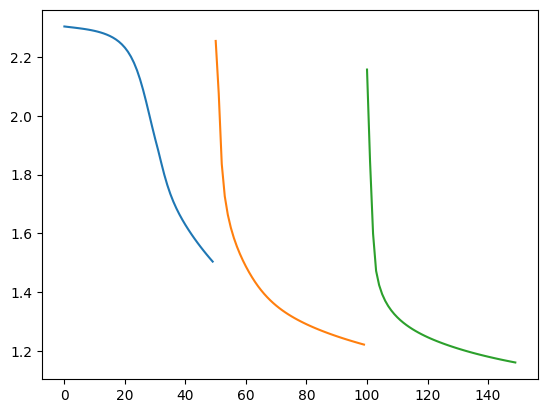

In [8]:
loss_plot(loss)

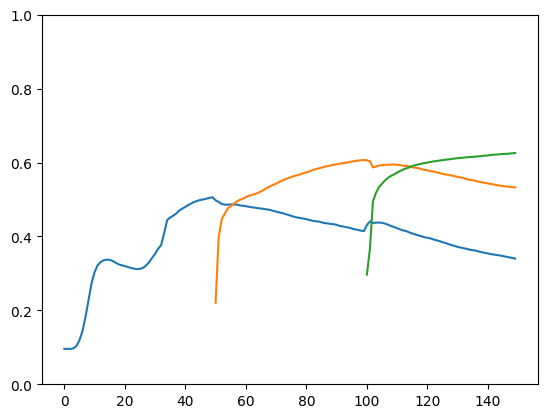

In [9]:
accuracy_plot(acc)

In [9]:
loss_ewc, acc_ewc = ewc_process(epochs, importance=1000, 
#                                 weight=weight
                               )

100%|██████████| 50/50 [04:36<00:00,  5.52s/it]


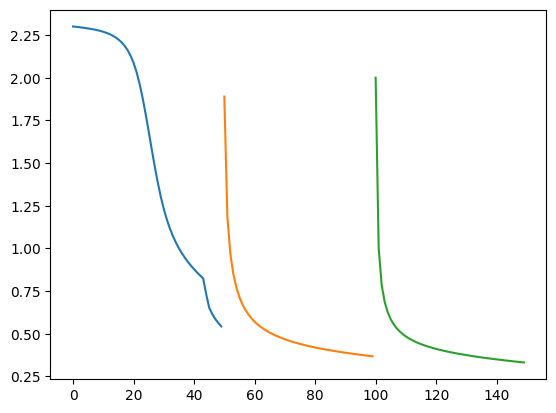

In [ ]:
loss_plot(loss_ewc)

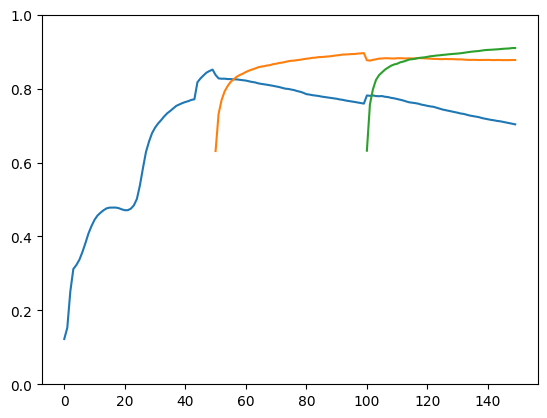

In [ ]:
accuracy_plot(acc_ewc)

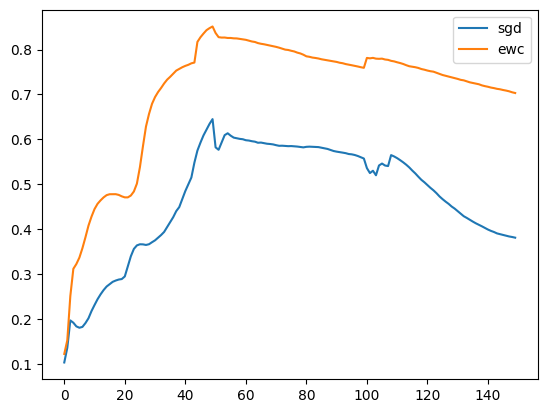

In [18]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()